## NuMI Analysis: numu/nue ratio study

#### Develop a numu selection for NuMI beam then do a numu/nue ratio study (inc energy + efficiency corrections) to constrain BNB low energy oscillation data.

First, setup.

In [1]:
%load_ext autoreload
%autoreload 2

#BDT

In [2]:
import sys
import localSettings as ls
import math
print(ls.main_path)

#BDT

/home/amoor/NuMI/NuMI_Analysis/PELEE


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

#BDT

In [4]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()
#print(numiBeamlineGeoWeights.calculateGeoWeight(14,0.01,5.))

#BDT

In [5]:
#test things are running

from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

#BDT

date and time: 10272021


In [6]:
# USING BDT?
USEBDT = True

In [7]:
# Doing Run3?
ISRUN3 = False

#BDT

In [8]:
# scale to MCC8 CV?
MCC8WEIGHTS = False

#BDT

In [9]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

#BDT

In [10]:
# This cell is all about translating the BNB reference frame to the NuMI on axis reference frame
# You can skip it if you're not planning on using angle variables

from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

#BDT

Now get some data.

In [11]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

# Name of root files for the various samples
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
DRT  = '/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
"""
BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
"""


#actually fetch datasets
mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [mc,nue,ext,data,dirt] 

# Define the variables you are going to load (less variables = less time)
# Some of them are common to all samples, others are present only in MC (like true variables)
# These are examples of variables common to all samples (there's more if you want!)

#To match Krishan's nue selection we need (1) nSlice (SliceID), n_showers_contained
#(2) xyz for reconstructed vertex, contained fraction of hits (3) cosmic impact params
#(4) hit ratio of leading shower to slice (5) moliere angle av, dEdx in first 4cm of shower, shower to vertex dist
#"shower_vtx_dist" not working?
#shr_energy, category, slnunhits, slnhits, slash time, ccnc, nu pdg needed later
variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton']

"""
varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
"""

# These are examples of variables present in MC samples only
varMC = ["nu_e","true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "elec_e"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
variables = list(set(variables))
print(variables)


# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


# Load the variables into your dataframes    
dirt = dirt.pandas.df(variables+varMC + WEIGHTS + SYSTEMATICS, flatten=False)
nue  = nue.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
mc   = mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext  = ext.pandas.df(variables, flatten=False)

#BDT

['shr_energy_cali', 'reco_nu_vtx_sce_y', 'category', 'shrsubclusters0', 'nproton', 'shr_tkfit_npoints', 'n_tracks_contained', 'slnunhits', 'topological_score', 'flash_time', 'trkshrhitdist2', 'run', 'selected', 'shr_score', 'nu_pdg', 'shr_tkfit_nhits_Y', 'hits_ratio', 'shrmoliereavg', 'shr_tkfit_dedx_Y', 'CosmicIPAll3D', 'n_showers', 'shr_energy', 'slnhits', 'shrsubclusters1', 'shrsubclusters2', 'shr_energy_tot_cali', 'ccnc', 'shr_tkfit_dedx_U', 'sub', 'tksh_distance', 'shr_tkfit_nhits_V', 'evt', 'trk_energy_tot', 'nslice', 'n_tracks', 'contained_fraction', 'tksh_angle', 'reco_nu_vtx_sce_x', 'shr_tkfit_dedx_V', 'shr_distance', 'trk_score_v', 'n_showers_contained', 'reco_nu_vtx_sce_z', 'shr_tkfit_nhits_U']


The following cell allows us to reload original data event weights. No weights have been added to data or ext so these are not included.

In [12]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    
#BDT

In [13]:
# Let's calculate the weights that we need to apply to the individual MC events 
# to become our best model of the NuMI data. 
# This cell calculates the GENIE Tune * PPFX correction to the MC weights and 
# cleans up extremely high (or low) weight scores (may be due to computational errors).
# The clean up is not the best practice (one should dig and understand why the weight are big/negative): 
# it's a cheat until we figure out the next best thing. Life is not perfect and your analysis won't be either. Please enojy LArbys

constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [mc,nue,dirt]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

#BDT

Get Log Likelihood Ratio Particle ID for track candidates. Will need proton for nue, muon for numu.

In [14]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!

#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [mc,nue,ext,data,dirt]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

#BDT

time to run:  1776.718988418579


In [15]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    #
    # secondshower_U/V/Y_dot need to be set to 9999. to match data ntuples produced with v08_00_00_43 or later;
    # the patch below is valid only to match data ntuples produced with v08_00_00_42.
    #
    #df.loc[df['secondshower_U_dot'].isna(),'secondshower_U_dot'] = 0.0 #for 0p please uncomment
    #df.loc[df['secondshower_V_dot'].isna(),'secondshower_V_dot'] = 0.0 #for 0p please uncomment
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 
    
#BDT

In [16]:
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
#    df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
#    df['shr_tkfit_nhi'] = (df['shr_tkfit_nhits_Y']*df['shr_tkfit_dedx_Y'] + df['shr_tkfit_nhits_U']*df['shr_tkfit_dedx_U'] + df['shr_tkfit_nhits_V']*df['shr_tkfit_dedx_V'])/df['shr_tkfit_nhits_tot']
#    df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
#    df['shr_tkfit_2cm_dedx_avg'] = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
#    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
#    df['shr_tkfit_gap10_dedx_avg'] = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    
    #BDT

In [17]:
#commented big tutorial had flash timer just before this

#Define neutrino reconstructed energy here
#Also make a correction to electron shower energies

INTERCEPT = 0.0
SLOPE = 0.83

df_v = [mc,nue,ext,data,dirt]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])
ext["extdata"] = np.ones_like(ext["shr_energy"])


#BDT

In [18]:
# add back the cosmic category, for background only
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    
#BDT    

In [19]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [mc,nue,dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

df_v = [ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359
        
#BDT        

In [20]:
#Define signal catagories

data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11

nue["is_not_signal"] = nue["category"] != 11

#BDT

In [21]:
# Some quick clean up since some strange events get in there
mc   = mc.query('nu_e > 0.')
nue  = nue.query('nu_e > 0.')
dirt = dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [mc,nue,dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    


## Selection Section

In [22]:
# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

print(PRESQ)

nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)


In [24]:
# Define actual selection

#QUERY = PRESQ
#QUERY = NPLCUTQ +" and "+ BDTCQ #PI0SEL#NUMUOnTheFly + ' and n_showers_contained == 1'  #PI0SEL#NPLCUTQ2 #NPLCUTQ #NPPRESQ#'nslice ==1 ' #NPPRESQ #PRESQ

# in case you do not want to look at the data
#QUERY += ' and bnbdata==0'

# in case you want to apply the CRT veto
#if ISRUN3: QUERY += ' and (crtveto!=1) and (_closestNuCosmicDist > 20.)'

In [23]:
df_v = [mc,nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

## Plotting Part

In [24]:
import plotter
import importlib
importlib.reload(plotter)
scaling = 1

SPLIT = 1.0
####Is this needed of new BDT?
#if (USEBDT == True):
#    SPLIT = 2.

#Define the samples to feed the plotter, as well as POT normalisation for each sample
#Need MC to be compariable to the data

fullnue = nue
#nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
# 254.8 & true_nu_vtx_x > -1.55 )")
nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
nue   = nue.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
 254.8 & true_nu_vtx_x > -1.55)")


samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "dirt": dirt,
    "ext": ext
}

scaling = 1
# This is the data POT we normalize to (comes from the data Ntuples)
pot =  2e+20 #partial file: 8.885e+19
# This is the full MC POT scaling factor
mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
# This is the POT scaling factor for the nue CC only sample
nueratio  = pot/2.37838e+22 #2.59311e+22 #norm for intrinsic = 2.59311e+22
# This is the POT scaling factor for dirt sample
dirtratio = pot/1.42143e+21
# The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
SPLIT = 1.0
# We scale down the EXT to account for neutrino occupancy
scalingEXT = 0.98
 # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
scalingDRT = 0.35


#Now we can define the sample normalization factors
weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : nueratio * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT, #set0   
            "dirt": dirtratio* SPLIT * scalingDRT, #set0   
}

print (ext.shape[0])
my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

#BDT

904362
{'mc': 0.08559738414394057, 'nue': 0.008409085175623745, 'ext': 0.5612087579382191, 'dirt': 0.049246181662128984}


Pre Selection Plots.

true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 12 and ccnc == 0)& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  0.06172974641404549  c  31
order w sum  0.16206110230596382  c  3
order w sum  13.037688436458543  c  4
order w sum  75.88883266632058  c  5
order w sum  223.7111688095107  c  0
order w sum  360.6659738488997  c  1
order w sum  32.10394283189026  c  12
order w sum  370.8856763625695  c  11
[0.02558536 0.03614439 0.         0.         0.         0.
 0.         0.         0.         0.        ]
sum:  0.061729746414045494
[0.06407157 0.11490107 0.03674458 0.00807363 0.         0.
 0.         0.         0.         0.        ]
sum:  0.2237908487200093
[1.1887709  4.39538272 3.49864718 1.67562897 1.06278395 0.59500141
 0.3521949  0.16811748 0.20261991 0.12233185]
sum:  13.261479285178556
[ 5.59964057 27.97226082 25.581389

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


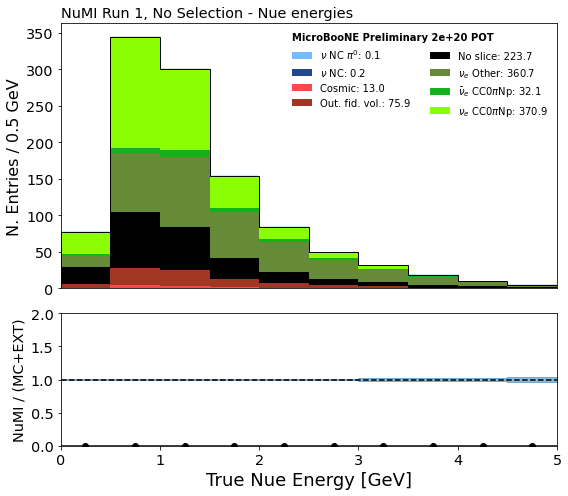

In [25]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???

VARIABLE, BINS, RANGE, XTIT = 'nu_e', 10, (0.0,5.0), r"True Nue Energy [GeV]"

#in the fiducial volume
fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 12 and ccnc == 0)"
FID_QUERY = fiduc

#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= FID_QUERY ,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = False, # need this to plot MC!
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_title('NuMI Run 1, No Selection - Nue energies',loc='left')
fig.tight_layout()
#fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTFinalFullMC/"+VARIABLE+"_varCV.pdf")
#print('%s %.4f %.4f %.4f ' % (VARIABLE, my_plotter.stats['pvalue'], my_plotter.stats['pvaluestatonly'],my_plotter.stats['pvaluediag'])+"\n")

true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 12 and ccnc == 0)& elec_e <= 5 & elec_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  0.06172974641404549  c  31
order w sum  0.16206110230596382  c  3
order w sum  13.17482786313895  c  4
order w sum  76.50848662782731  c  5
order w sum  225.4668037720339  c  0
order w sum  367.77205784094343  c  1
order w sum  32.30309094298367  c  12
order w sum  371.4587617670574  c  11
[0.062 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
sum:  0.061729746414045494
[0.224 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
sum:  0.22379084872000932
[2.197 3.479 2.283 1.718 1.265 0.619 0.53  0.358 0.187 0.24  0.164 0.119
 0.058 0.029 0.075 0.041 0.02  0.    0.017 0.   ]
sum:  13.39861

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


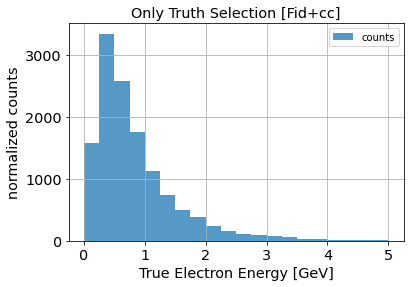

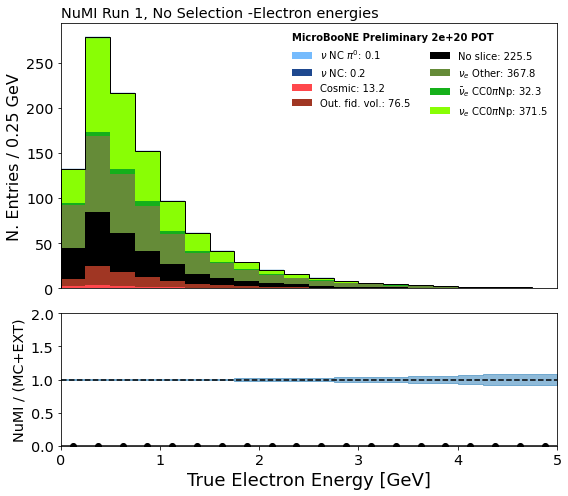

In [26]:
import matplotlib.pyplot as plt
import matplotlib

#in the fiducial volume
fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55"

#just look for electon neutrinos
q2 = "(abs(nu_pdg) == 12 and ccnc == 0) and " + fiduc
#in the mc data
nueMCSel  = mc.query(q2)

fig, ax = plt.subplots(nrows=1, sharex=True)

#n1, bins1, patches1 = ax[0].hist('elec_e',25,weights='weightSplineTimesTuneTimesPPFX',  range=(0,5), alpha=0.75, label='Elec')
n2, bins2, patches2 = ax.hist(nueMCSel['elec_e'],20,weights=nueMCSel['weightSplineTimesTuneTimesPPFX'],  range=(0,5), alpha=0.75, label='counts')

ax.set_xlabel('True Electron Energy [GeV]')
ax.set_ylabel('normalized counts')
ax.set_title('Only Truth Selection [Fid+cc]')
ax.legend()
ax.grid(True)

############################################

VARIABLE, BINS, RANGE, XTIT = 'elec_e', 20, (0.0,5.0), r"True Electron Energy [GeV]"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= FID_QUERY ,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = False, # need this to plot MC!
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, No Selection -Electron energies',loc='left')
fig.tight_layout()


In [2]:
# from Katerina  - modified, to be able to plot truth mc with nue eff selections
# plot efficiency overlaid on selected signal events 
def plot_signal_and_eff(selected, df, signal, bins, truth): 
    
    # generated true signal events per bin 
    gen = plt.hist(df.query(signal)['nu_e'], bins, color='orange')
    plt.close()
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    sel = ax1.hist(truth['nu_e'], bins, color='orange')
    ax1.set_ylabel('selected signal events', fontsize=15)
    ax1.set_xlabel('true nue energy [GeV]', fontsize=15)

    # compute efficiency
    #sel2=selected['nu_e']
    sel = ax1.hist(selected['nu_e'], bins, color='white')
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    sel = ax1.hist(truth['nu_e'], bins, color='orange')
    ax1.set_ylim(0, 6000)
    ax2 = ax1.twinx()
    ax2.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='seagreen', ecolor='seagreen', markersize=3) 
    ax2.set_ylim(0, 1.00)
    ax2.set_ylabel('Efficiency', fontsize=15)
    ax2.set_title("Variable and Efficiency plot")

    plt.show()

In [1]:
######################

## BDT

In [25]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [26]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/amoor/NuMI/NuMI_Analysis/bdt_model_feb2021.model')

In [27]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]

datasetlist = [mc, nue, dirt, ext, data]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(914729, 109)


/home/amoor/miniconda3/envs/python3NuMIWS/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/amoor/miniconda3/envs/python3NuMIWS/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/amoor/miniconda3/envs/python3NuMIWS/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value

(126999, 110)
(483722, 91)
(904362, 63)
(610496, 63)


In [28]:
datasets_bdt = mc

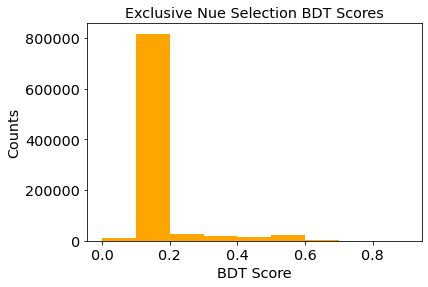

In [29]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [ ]:
###Need to use the same BDT split value Katerina did
#It was BDT score > 0.575

BDT_score > 0.575& BDT_score <= 1 & BDT_score >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  3.615624304106091  c  5
order w sum  4.843611986956745  c  3
order w sum  8.129856740780127  c  4
order w sum  21.806738351944173  c  31
order w sum  24.95818446173621  c  2
order w sum  46.108356604244385  c  21
order w sum  23.37608166150855  c  1
order w sum  7.425211449737144  c  12
order w sum  99.66674652170425  c  11
[0.         0.         0.         0.         0.         1.19511905
 1.61690297 0.69578435 0.10781794 0.        ]
sum:  3.6156243041060914
[0.         0.         0.         0.         0.         3.09030713
 4.08592716 1.17518407 0.10781794 0.        ]
sum:  8.459236291062837
[0.         0.         0.         0.         0.         5.62417832
 8.61250935 2.24458741 0.10781794 0.        ]
sum:  16.589093031842967
[ 0.          0.          0.          0.          0.         11.60578268
 21.87162383  4.72222714  0.19619773  0.        ]
sum:  38.39583138378713


/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:2281: RuntimeWarning: divide by zero encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


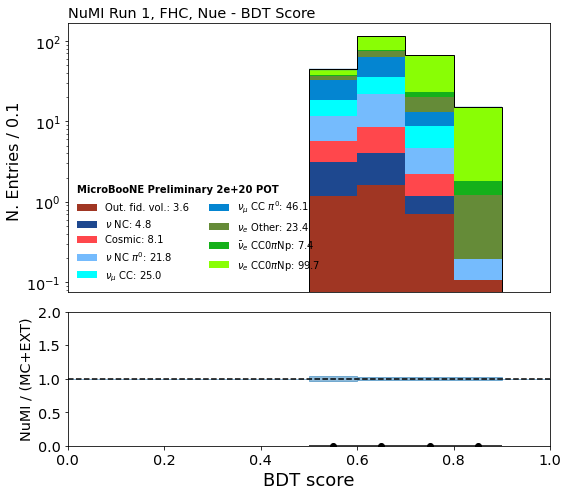

In [30]:
import matplotlib.pyplot as plt
import matplotlib

SEL_QUERY = "BDT_score > 0.575"

VARIABLE, BINS, RANGE, XTIT = 'BDT_score',10,(0.0, 1.0),"BDT score"
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = False, 
    draw_data = False,           #False as plotting MC
    #genieweight = "totweight_overlay",
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before.
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, Nue - BDT Score',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

In [31]:
#Save the DataFrame to a csv file to check for any crossover in datapoints
selected = nue.query(SEL_QUERY)
fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 12 and ccnc == 0) and nproton > 0"
selected_fid = selected.query(fiduc_q)
#selected_fid.to_csv('nue_full_mc.csv')

BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  3.615624304106091  c  5
order w sum  4.843611986956745  c  3
order w sum  8.129856740780127  c  4
order w sum  21.806738351944173  c  31
order w sum  24.95818446173621  c  2
order w sum  46.108356604244385  c  21
order w sum  23.344544773736892  c  1
order w sum  7.402086826382965  c  12
order w sum  99.5428391477295  c  11
[1.329 1.93  0.186 0.129 0.018 0.025 0.    0.    0.    0.   ]
sum:  3.615624304106091
[3.073 4.223 0.703 0.306 0.129 0.025 0.    0.    0.    0.   ]
sum:  8.459236291062837
[5.58  7.498 2.119 0.607 0.486 0.179 0.    0.045 0.075 0.   ]
sum:  16.589093031842964
[12.162 19.658  3.895  1.415  0.692  0.225  0.161  0.045  0.143  0.   ]
sum:  38.39583138378713
[26.415 27.785  5.856  1.959  0.766  0.225  0.161  0.045  0.143  0.   ]
sum:  63.35401584552333
[4.169e+01 4.998e+01 1.153e+01 4.102e+00 1.253e+00 4.736e-01 1.605e-01
 4.477e-02 2.279e-01 0.000e+00]
sum:  109.46

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:267: RuntimeWarning: divide by zero encountered in true_divide
  return (data-mc)**2 / data


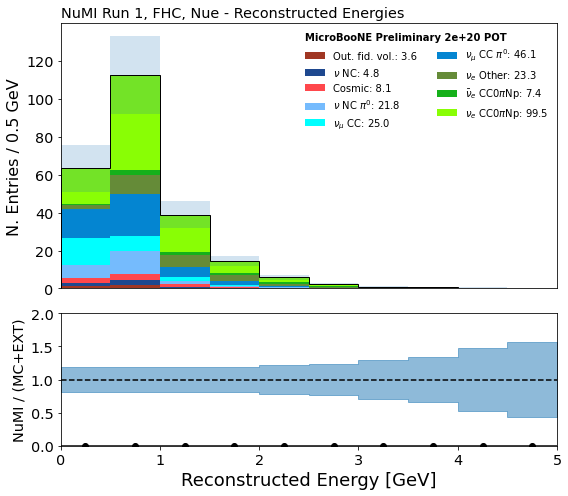

In [32]:
#Now check on a variable


import matplotlib.pyplot as plt
import matplotlib

VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = True, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

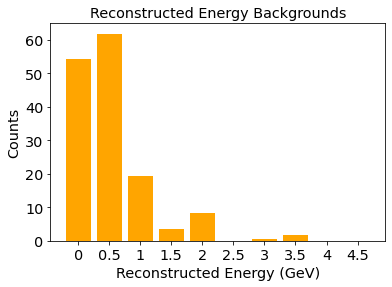

In [31]:
#Background numbers plot

bkg_nums = [54.235, 61.865, 19.335, 3.661, 8.327, 0, 0.582, 1.726, 0, 0]

import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 5, 0.5)
names = ['0', '0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5']
#gen = plt.hist(bkg_nums, bins, color='orange')
plt.bar(names, bkg_nums, color='orange')
plt.xlabel("Reconstructed Energy (GeV)")
plt.ylabel("Counts")
plt.title("Reconstructed Energy Backgrounds")
plt.show()

In [33]:
# from Katerina  - modified, to be able to plot truth mc with nue eff selections
# plot efficiency overlaid on selected signal events 
def plot_signal_and_eff(selected, df, signal, bins, truth): 
    
    # generated true signal events per bin 
    gen = plt.hist(df.query(signal)['nu_e'], bins, color='deepskyblue')
    plt.close()
    print("Full numbers = ", gen[0])
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    ax1.set_ylabel('Selected Signal Events', fontsize=15)
    ax1.set_xlabel('True Nue Energy [GeV]', fontsize=15)

    # compute efficiency
    #sel2=selected['nu_e']
    sel = ax1.hist(selected['nu_e'], bins, color='white')
    print("Selected numbers = ", sel[0])
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        print("In bin", i, ", eff = ", eff[i], " with error = ", eff_err[i])
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    ax1.set_ylim(0, 3500)
    ax2 = ax1.twinx()
    ax2.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='orangered', ecolor='orangered', markersize=3) 
    ax2.set_ylim(0, 1.00)
    ax2.set_ylabel('Efficiency', fontsize=15)
    ax2.set_title("True Nue Energy and Efficiency")
    plt.text(0, 0.95, r'MicroBooNE Preliminary', fontweight='bold')

    plt.show()

Full numbers =  [ 536. 2893. 2706. 1335.  740.  395.  254.  130.   82.   50.]
Selected numbers =  [ 52. 484. 429. 153.  86.  50.  22.   9.   8.   2.]
In bin 0 , eff =  0.09701492537313433  with error =  0.012784306321107221
In bin 1 , eff =  0.16730038022813687  with error =  0.0069393442125408105
In bin 2 , eff =  0.15853658536585366  with error =  0.0070213152524123265
In bin 3 , eff =  0.1146067415730337  with error =  0.008718314974769211
In bin 4 , eff =  0.11621621621621622  with error =  0.01178122689571765
In bin 5 , eff =  0.12658227848101267  with error =  0.016730114230512443
In bin 6 , eff =  0.08661417322834646  with error =  0.01764837640859673
In bin 7 , eff =  0.06923076923076923  with error =  0.022263780490101512
In bin 8 , eff =  0.0975609756097561  with error =  0.032767256047401334
In bin 9 , eff =  0.04  with error =  0.027712812921102035


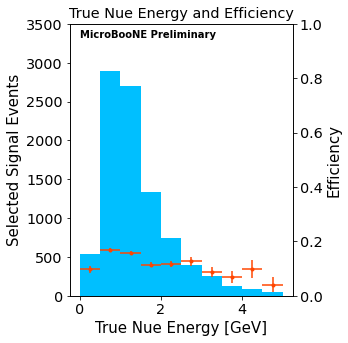

In [34]:
SEL_QUERY = "BDT_score > 0.575"
#selected = nue.query(SEL_QUERY)


fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 12 and ccnc == 0) and nproton > 0"


#bins = [0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.05, 2.25, 2.45, 2.65, 2.85, 3.05]
bins = np.arange(0, 5.5, 0.5)
#plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

selected = mc.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

plot_signal_and_eff(selected_fid, mc, fiduc_q, bins, mc.query(fiduc_q))

### Smearing Matrix work

In [35]:
# plot the smearing matrix 
def plot_smearing(selected, signal, true, reco, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(selected.query(signal)[true],selected.query(signal)[reco],
                   bins, cmin=0.000000001, cmap='OrRd')

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1): 
                norm_array[i][j] =  norm_array[i][j] / tot_reco_events
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
    
        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of Reco Events in True Bin', fontsize=15)

    plt.xlabel('True Nu Energy [GeV]', fontsize=15)
    plt.ylabel('Reco Nu Energy [GeV]', fontsize=15)
    plt.text(0.1, 4.8, r'MicroBooNE Preliminary', fontweight='bold')
    
    plt.show()

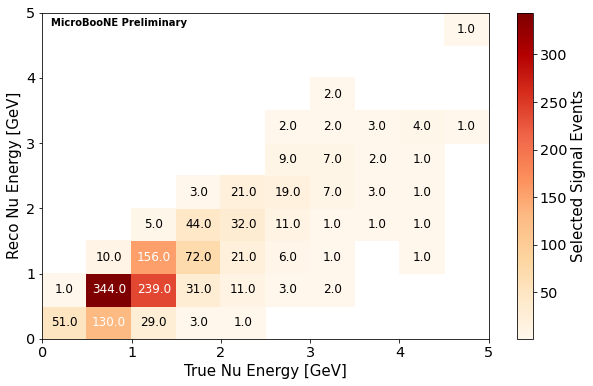

In [36]:
# true nu energy 
true_var = 'nu_e'

# reconstructed nu energy 
reco_var = 'reco_e'

bins = np.arange(0, 5.5, 0.5)

# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins)

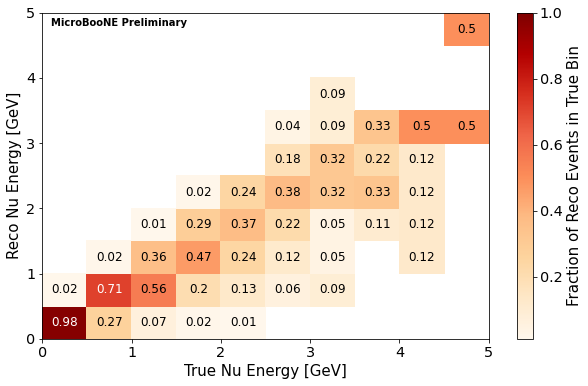

In [37]:
# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins, norm=True)

In [38]:
# Calculate true numbers
#bkg_nums = [54.235, 61.865, 19.335, 3.661, 8.327, 0, 0.582, 1.726, 0, 0]
#n_data = [73, 112, 39, 10, 11, 0, 1, 2, 0, 0]
n_selected = [18.765, 50.135, 19.665, 6.339, 2.673, 1.126, 0.418, 0.274, 0.08907, 0.0583]

true0 = (n_selected[0]*0.98) + (n_selected[1]*0.02)
true05 = (n_selected[0]*0.27) + (n_selected[1]*0.71) + (n_selected[2]*0.02)
true1 = (n_selected[0]*0.07) + (n_selected[1]*0.56) + (n_selected[2]*0.36) + (n_selected[3]*0.01)
true15 = (n_selected[0]*0.02) + (n_selected[1]*0.2) + (n_selected[2]*0.47) + (n_selected[3]*0.29) + (n_selected[4]*0.02)
true2 = (n_selected[0]*0.01) + (n_selected[1]*0.13) + (n_selected[2]*0.24) + (n_selected[3]*0.37) + (n_selected[4]*0.24)
true25 = (n_selected[1]*0.06) + (n_selected[2]*0.12) + (n_selected[3]*0.22) + (n_selected[4]*0.38) + (n_selected[5]*0.18) + (n_selected[6]*0.04)
true3 = (n_selected[1]*0.09) + (n_selected[2]*0.05) + (n_selected[3]*0.05) + (n_selected[4]*0.32) + (n_selected[5]*0.32) + (n_selected[6]*0.09) + (n_selected[7]*0.09)
true35 = (n_selected[3]*0.11) + (n_selected[4]*0.33) + (n_selected[5]*0.22) + (n_selected[6]*0.33)
true4 = (n_selected[2]*0.12) + (n_selected[3]*0.12) + (n_selected[4]*0.12) + (n_selected[5]*0.12) + (n_selected[6]*0.5)
true45 = (n_selected[6]*0.5) + (n_selected[9]*0.5)

In [39]:
#multiply by efficiency and sum

eff = [0.09701492537313433, 0.16730038022813687, 0.15853658536585366, 0.1146067415730337, 0.11621621621621622, 0.12658227848101267, 0.08661417322834646, 0.06923076923076923, 0.0975609756097561, 0.04]
truths = [true0, true05, true1, true15, true2, true25, true3, true35, true4, true45]
ratio_nums = []

for i in range(len(truths)):
    num = truths[i]*(1/eff[i])
    ratio_nums.append(num)
    
print("Numbers of Ratio, nue: ", ratio_nums)
print("Ratio number, nue: ", sum(ratio_nums))


Numbers of Ratio, nue:  [199.8908923076923, 245.40111590909092, 230.4322369230769, 187.9175666666667, 124.00808139534882, 63.181198, 81.86085181818181, 28.383911111111107, 38.79994, 5.95375]
Ratio number, nue:  1205.8295441311686


### Ratio Calculation

In [43]:
numu_ratio_nums = [199.8908923076923, 245.40111590909092, 230.4322369230769, 187.9175666666667, 124.00808139534882, 63.181198, 81.86085181818181, 28.383911111111107, 38.79994, 5.95375]
nue_ratio_nums = [169.65557084690553, 236.25330795610427, 219.64615869792848, 154.48206614192907, 112.50032740259738, 87.20084442516269, 59.47250931034483, 94.09295064390247, 93.96329558309857, 50.10685366666666]
bin_ratios = []

for i in range(len(numu_ratio_nums)):
    ratio = nue_ratio_nums[i]/numu_ratio_nums[i]
    bin_ratios.append(ratio)
    
print(bin_ratios)

[0.18943664367064422, 0.22275933487506627, 0.25931459659901207, 0.27145557801670567, 0.24747569402925496, 0.2444173751971049, 0.21925017560821927, 0.3473526083186562, 0.41063759221785096, 0.23375382515513637]


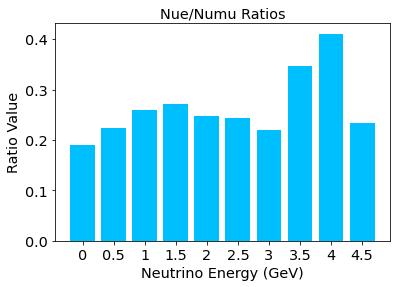

In [58]:
bins = np.arange(0, 5.5, 0.5)
names = ['0', '0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5']
#gen = plt.hist(bkg_nums, bins, color='orange')
plt.bar(names, bin_ratios, color='deepskyblue')
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel("Ratio Value")
plt.title("Nue/Numu Ratios")
plt.show()

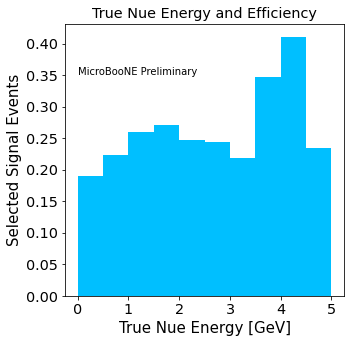

In [68]:
    count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]
    
    weights = [0.1*0.18943664367064422, 0.6*0.22275933487506627, 1.1*0.25931459659901207, 1.6*0.27145557801670567, 2.1*0.24747569402925496, 2.6*0.2444173751971049, 3.1*0.21925017560821927, 3.6*0.3473526083186562, 4.1*0.41063759221785096, 4.6*0.23375382515513637]
    
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(5, 5))
    
    sel = ax1.hist(count, bins, color='deepskyblue', weights=bin_ratios)
    ax1.set_ylabel('Selected Signal Events', fontsize=15)
    ax1.set_xlabel('True Nue Energy [GeV]', fontsize=15)
    #ax1.set_ylim(0, 3500)
    ax1.set_title("True Nue Energy and Efficiency")
    
    plt.text(0, 0.35, r'MicroBooNE Preliminary')
    plt.show()